In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("src/")
from src.transport_model import TransportModel, TransportDataset, get_model_inputs, ModelEnsemble
from src.db_handler import DB_handler
import pandas as pd
import torch
from src.constants import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns

In [3]:
ensemble_scaling_laws = ModelEnsemble(10)
ensemble_scaling_laws.load("db6june_with_ions_40epochs")

In [4]:
db = DB_handler("data/db6june.feather")
data = db.valid()

In [5]:
te_scale = torch.linspace(0, 8, 100)
ti_scale = torch.linspace(0, 8, 100)
te_scale_index = db[MODEL_INPUTS].columns.get_loc(TE_SCALE)
ti_scale_index = db[MODEL_INPUTS].columns.get_loc(TI_SCALE)

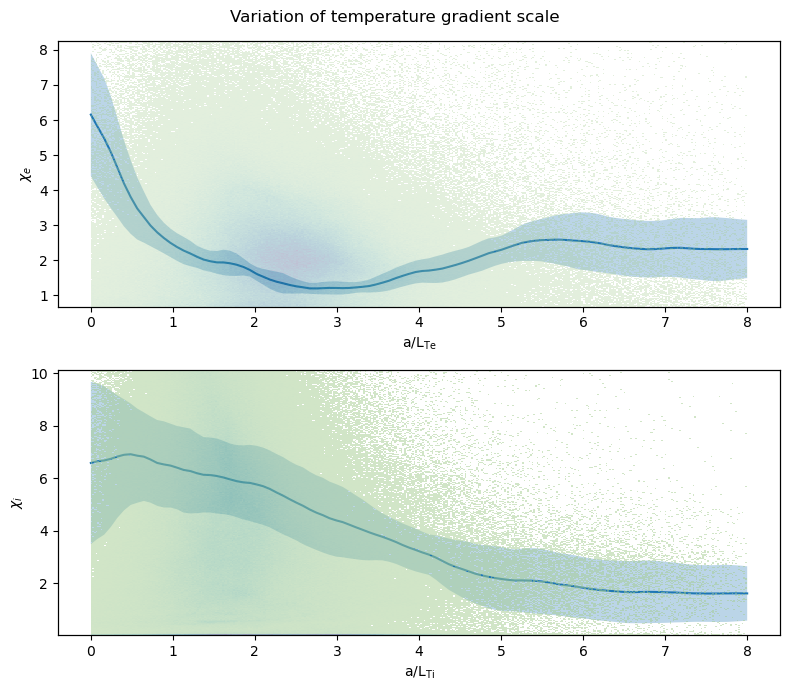

In [25]:
fits_electron = []
fits_ion = []
inputs = get_model_inputs(db.valid()[MODEL_INPUTS].median())
for te in te_scale:
    inputs[te_scale_index] = te.item()
    fits_electron.append(ensemble_scaling_laws.predict(inputs))
for ti in ti_scale:
    inputs[ti_scale_index] = ti.item()
    fits_ion.append(ensemble_scaling_laws.predict(inputs))

fits_electron = np.array(fits_electron)    
fits_ion = np.array(fits_ion)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,7))

std_e = fits_electron[:, :, 0].std(axis=1)
mean_e = fits_electron[:, :, 0].mean(axis=1)
ax1.plot(te_scale, mean_e)
ax1.fill_between(te_scale, mean_e-std_e, mean_e+std_e, alpha=0.3)

ax3 = ax1.twinx()
ax3.set_ylim(0, 8)
sns.histplot(
    data=data,
    x=TE_SCALE,
    y=CHI_ELECTRON,
    bins=(400,400), cmap = "crest", alpha=0.3,
    ax = ax3
)
ax3.set_ylabel("")
ax3.set_yticks([])

std_i = fits_ion[:, :, 1].std(axis=1)
mean_i = fits_ion[:, :, 1].mean(axis=1)
ax2.plot(ti_scale, mean_i)
ax2.fill_between(ti_scale, mean_i-std_i, mean_i+std_i, alpha=0.3)

ax4 = ax2.twinx()
ax4.set_ylim(0, 8)
sns.histplot(
    data=data,
    x=TI_SCALE,
    y=CHI_ION,
    bins=(400,400), cmap = "crest", alpha=0.5,
    ax = ax4
)
ax4.set_ylabel("")
ax4.set_yticks([])

ax1.set_ylabel(r"$\chi_e$")
ax1.set_xlabel(r"$\mathrm{a/L_{Te}}$")
ax2.set_ylabel(r"$\chi_i$")
ax2.set_xlabel(r"$\mathrm{a/L_{Ti}}$")
plt.suptitle("Variation of temperature gradient scale")
plt.tight_layout()
plt.savefig("../Thesis/Chapters/5-Results/img/temp_scale_scan.png")

In [6]:
te_scale = torch.linspace(0, 6, 100)
ti_scale = torch.linspace(0, 6, 100)

In [7]:
def perform_scan(ensemble, inital_input, field_to_vary, field_values, ions=False):
    
    field_index = db[MODEL_INPUTS].columns.get_loc(field_to_vary)
      
    all_fits = []
    for field_value in field_values:
        inital_input[field_index] = field_value
        fits = []
        scale = ti_scale if ions else te_scale
        scale_index = ti_scale_index if ions else te_scale_index
        for s in scale:
            inital_input[scale_index] = s.item()
            fits.append(ensemble.predict(inital_input))
        all_fits.append(fits)
    all_fits = np.array(all_fits)
    return all_fits

In [8]:
q_values = [1.1, 1.5, 2, 3]
inputs = get_model_inputs(db.valid()[MODEL_INPUTS].median())
q_scan_electron = perform_scan(ensemble_scaling_laws, inputs, Q_SAFETY, q_values, False)
q_scan_ions = perform_scan(ensemble_scaling_laws, inputs, Q_SAFETY, q_values, True)

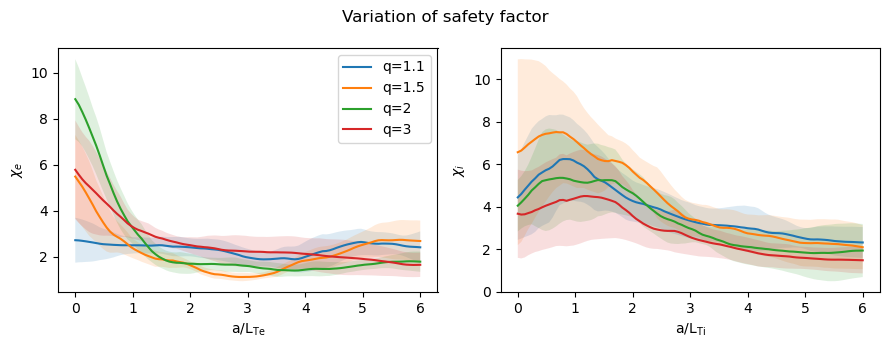

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3.5))

for i, q in enumerate(q_scan_electron):
    mean = q_scan_electron[i, :, :, 0].mean(axis=1)
    std = q_scan_electron[i, :, :, 0].std(axis=1)
    ax1.plot(te_scale, mean, label=f"q={q_values[i]}")
    ax1.fill_between(te_scale, mean-std, mean+std, alpha=0.15)
    
for i, q in enumerate(q_scan_ions):
    mean = q_scan_ions[i, :, :, 1].mean(axis=1)
    std = q_scan_ions[i, :, :, 1].std(axis=1)
    ax2.plot(te_scale, mean, label=f"q={q_values[i]}")
    ax2.fill_between(te_scale, mean-std, mean+std, alpha=0.15)
    
ax1.legend()
ax1.set_ylabel(r"$\chi_e$")
ax1.set_xlabel(r"$\mathrm{a/L_{Te}}$")
ax2.set_ylabel(r"$\chi_i$")
ax2.set_xlabel(r"$\mathrm{a/L_{Ti}}$")
plt.suptitle("Variation of safety factor")
plt.tight_layout()
plt.savefig("../Thesis/Chapters/5-Results/img/q_scan.png")


In [10]:
t_ratio_values = [0.8, 1, 1.5, 2]
inputs = get_model_inputs(db.valid()[MODEL_INPUTS].median())
t_ratio_scan_electron = perform_scan(ensemble_scaling_laws, inputs, T_RATIO, t_ratio_values, False)
t_ratio_scan_ions = perform_scan(ensemble_scaling_laws, inputs, T_RATIO, t_ratio_values, True)

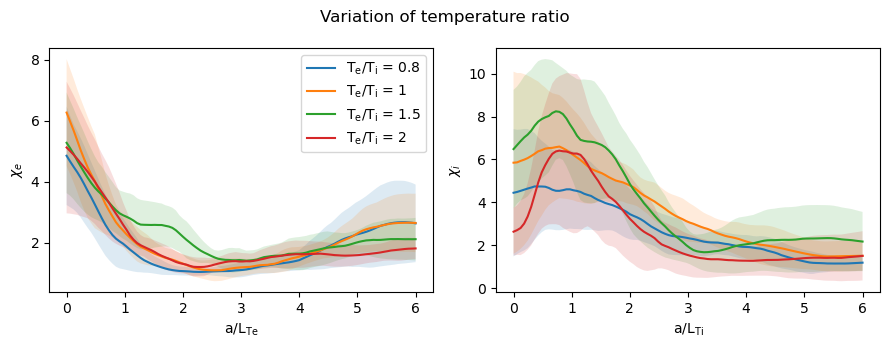

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3.5))

for i, q in enumerate(t_ratio_scan_electron):
    mean = t_ratio_scan_electron[i, :, :, 0].mean(axis=1)
    std = t_ratio_scan_electron[i, :, :, 0].std(axis=1)
    ax1.plot(te_scale, mean, label=(r"$\mathrm{T_e/T_i}$ = " + f"{t_ratio_values[i]}"))
    ax1.fill_between(te_scale, mean-std, mean+std, alpha=0.15)
    
for i, q in enumerate(t_ratio_scan_ions):
    mean = t_ratio_scan_ions[i, :, :, 1].mean(axis=1)
    std = t_ratio_scan_ions[i, :, :, 1].std(axis=1)
    ax2.plot(te_scale, mean, label=r"$T_e/T_i$={}".format(t_ratio_values[i]))
    ax2.fill_between(te_scale, mean-std, mean+std, alpha=0.15)
    
ax1.legend()
ax1.set_ylabel(r"$\chi_e$")
ax1.set_xlabel(r"$\mathrm{a/L_{Te}}$")
ax2.set_ylabel(r"$\chi_i$")
ax2.set_xlabel(r"$\mathrm{a/L_{Ti}}$")
plt.suptitle("Variation of temperature ratio")
plt.tight_layout()
plt.savefig("../Thesis/Chapters/5-Results/img/t_ratio_scan.png")


In [12]:
shear_values = [10, 50, 100, 200]
inputs = get_model_inputs(db.valid()[MODEL_INPUTS].median())
t_ratio_scan_electron = perform_scan(ensemble_scaling_laws, inputs, Q_SAFETY_SHEAR, shear_values, False)
t_ratio_scan_ions = perform_scan(ensemble_scaling_laws, inputs, Q_SAFETY_SHEAR, shear_values, True)

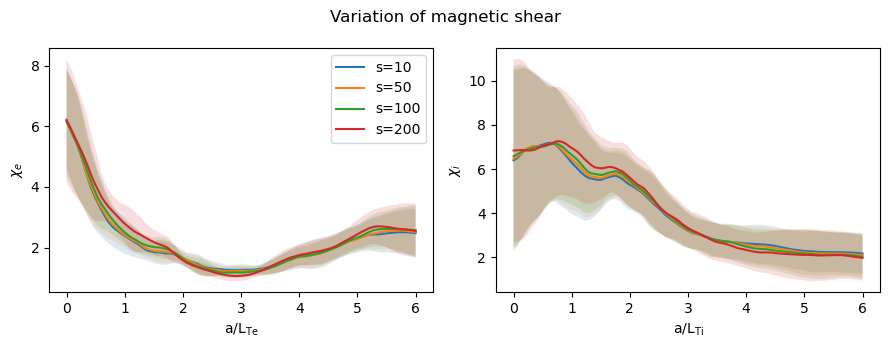

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3.5))

for i, q in enumerate(t_ratio_scan_electron):
    mean = t_ratio_scan_electron[i, :, :, 0].mean(axis=1)
    std = t_ratio_scan_electron[i, :, :, 0].std(axis=1)
    ax1.plot(te_scale, mean, label=f"s={shear_values[i]}")
    ax1.fill_between(te_scale, mean-std, mean+std, alpha=0.15)
    
for i, q in enumerate(t_ratio_scan_ions):
    mean = t_ratio_scan_ions[i, :, :, 1].mean(axis=1)
    std = t_ratio_scan_ions[i, :, :, 1].std(axis=1)
    ax2.plot(te_scale, mean, label=f"s={shear_values[i]}")
    ax2.fill_between(te_scale, mean-std, mean+std, alpha=0.15)
    
ax1.legend()
ax1.set_ylabel(r"$\chi_e$")
ax1.set_xlabel(r"$\mathrm{a/L_{Te}}$")
ax2.set_ylabel(r"$\chi_i$")
ax2.set_xlabel(r"$\mathrm{a/L_{Ti}}$")
plt.suptitle("Variation of magnetic shear")
plt.tight_layout()
plt.savefig("../Thesis/Chapters/5-Results/img/s_scan.png")
